# Training Final Model

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import optuna
import lightgbm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, auc, roc_curve, confusion_matrix, precision_recall_curve
from datetime import datetime

import os
import yaml
import sys

sys.path.append('../src')
import utils.utils as utils

!pip freeze > ../requirements.txt

In [4]:
train_set = pd.read_csv('../data/cleaned_train_data.csv')
test_set = pd.read_csv('../data/cleaned_test_data.csv')

X_train = train_set.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_train = train_set.TARGET
X_test = test_set.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_test = test_set.TARGET

# Double check categorical cols
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object' or X_train[col].dtype == 'category']
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

## Model training with optimized params

### Train model

In [6]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=810)

models = []
feature_importances = []

with open('../configs/model_config.yaml', 'r') as file:
    params = yaml.safe_load(file)

params['objective'] = 'binary'
params['metric'] = 'auc'
params['verbosity'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 810

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    print(f"Training Fold {fold+1}")
    X_train_kf, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_kf, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    train_data = lightgbm.Dataset(X_train_kf, label=y_train_kf, categorical_feature=cat_cols)
    val_data = lightgbm.Dataset(X_val, label=y_val, reference=train_data)
    
    model = lightgbm.train(
        params,
        train_data,
        valid_sets=[train_data, val_data],
        num_boost_round=1000,
        callbacks=[
            lightgbm.early_stopping(stopping_rounds=50),
        ]
    )
    models.append(model)
    feature_importances.append(model.feature_importance())

Training Fold 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[851]	training's auc: 0.867293	valid_1's auc: 0.774376
Training Fold 2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[936]	training's auc: 0.871597	valid_1's auc: 0.775216
Training Fold 3
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	training's auc: 0.8771	valid_1's auc: 0.776762
Training Fold 4
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[994]	training's auc: 0.877073	valid_1's auc: 0.77114
Training Fold 5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[832]	training's auc: 0.864302	valid_1's auc: 0.76759


### Calculate ROC AUC and GINI for ensembled model

In [7]:
preds = np.zeros(len(X_test))
# Calculate and print the ROC AUC
for model in models:
    preds += model.predict(X_test) / len(models)
roc_auc = roc_auc_score(y_test, preds)

# Calculate GINI
gini = 2 * roc_auc - 1
print(f"ROC AUC: {roc_auc}")
print(f"GINI: {gini}")

ROC AUC: 0.7779534976791839
GINI: 0.5559069953583677


In [8]:
# Get the current datetime
current_datetime = datetime.now().strftime('%y-%m-%d_%H-%M-%S')

for i, model in enumerate(models):
    model.save_model(f'../models/{current_datetime}_lgbm_fold_{i+1}.txt')

## Validating Model

In [9]:
cm = confusion_matrix(y_test, preds.round())
cm

array([[56441,    96],
       [ 4805,   160]])

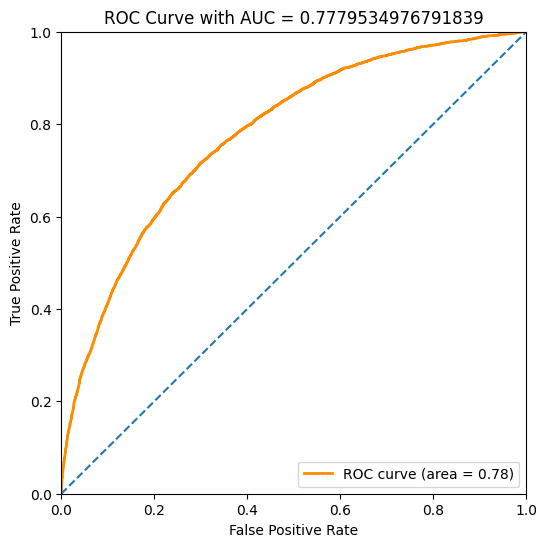

In [10]:
fpr, tpr, thres = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

def _plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, linestyle='-', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], '--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curve with AUC = {}'.format(roc_auc))

_plot_roc_curve(fpr, tpr, roc_auc)

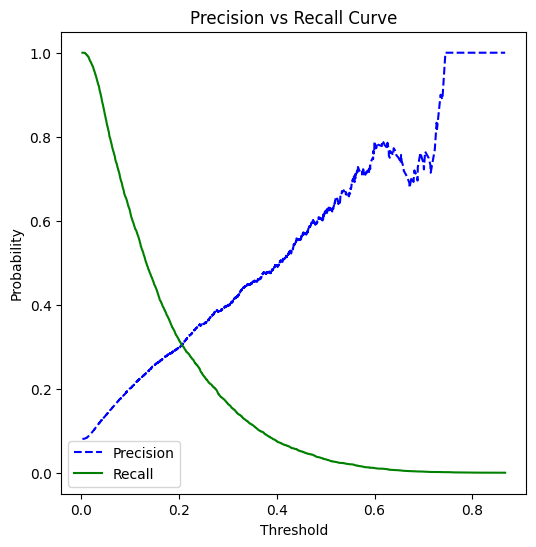

In [11]:
precision, recall, thres = precision_recall_curve(y_test, preds)

def _plot_prec_rec_curve(prec, rec, thres):
    plt.figure(figsize=(6,6))
    plt.plot(thres, prec[:-1], 'b--', label = 'Precision')
    plt.plot(thres, rec[:-1], 'g-', label = 'Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Probability')
    plt.title('Precision vs Recall Curve')
    plt.legend()

_plot_prec_rec_curve(precision, recall, thres)

In [23]:
current_datetime = datetime.now().strftime('%y-%m-%d_%H-%M-%S')
# Export y_test and preds to csv
y_test_preds = pd.DataFrame({'y_test': y_test, 'preds': preds})
y_test_preds.to_csv(f'../log/preds/{current_datetime}_predictions.csv', index=False)

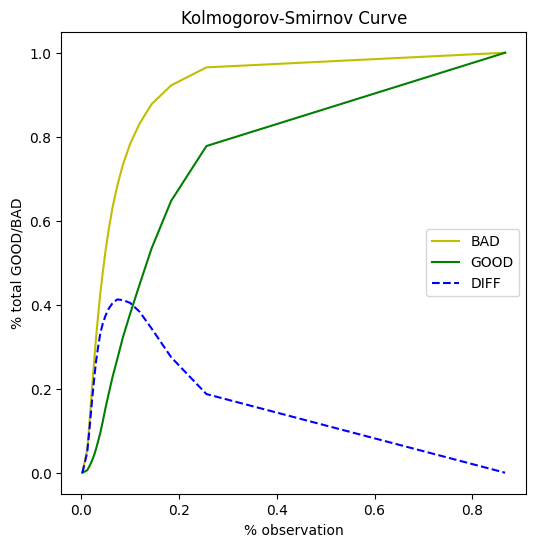

In [12]:
def _KM(y_pred, n_bins):
    _, thresholds = pd.qcut(y_pred, q=n_bins, retbins=True)
    cmd_BAD = []
    cmd_GOOD = []
    BAD_id = set(np.where(y_test == 0)[0])
    GOOD_id = set(np.where(y_test == 1)[0])
    total_BAD = len(BAD_id)
    total_GOOD = len(GOOD_id)
    for thres in thresholds:
      pred_id = set(np.where(y_pred <= thres)[0])
      # Đếm % số lượng hồ sơ BAD có xác suất dự báo nhỏ hơn hoặc bằng thres
      per_BAD = len(pred_id.intersection(BAD_id))/total_BAD
      cmd_BAD.append(per_BAD)
      # Đếm % số lượng hồ sơ GOOD có xác suất dự báo nhỏ hơn hoặc bằng thres
      per_GOOD = len(pred_id.intersection(GOOD_id))/total_GOOD
      cmd_GOOD.append(per_GOOD)
    cmd_BAD = np.array(cmd_BAD)
    cmd_GOOD = np.array(cmd_GOOD)
    return cmd_BAD, cmd_GOOD, thresholds

cmd_BAD, cmd_GOOD, thresholds = _KM(preds, n_bins=20)

def _plot_KM(cmd_BAD, cmd_GOOD, thresholds):
    plt.figure(figsize = (6, 6))
    plt.plot(thresholds, cmd_BAD, 'y-', label = 'BAD')
    plt.plot(thresholds, cmd_GOOD, 'g-', label = 'GOOD')
    plt.plot(thresholds, cmd_BAD-cmd_GOOD, 'b--', label = 'DIFF')
    plt.xlabel('% observation')
    plt.ylabel('% total GOOD/BAD')
    plt.title('Kolmogorov-Smirnov Curve')
    plt.legend()

_plot_KM(cmd_BAD, cmd_GOOD, thresholds)

In [17]:
print('KS Test Result:\n', stats.ks_2samp(cmd_BAD, cmd_GOOD))

KS Test Result:
 KstestResult(statistic=np.float64(0.38095238095238093), pvalue=np.float64(0.09481656218610322), statistic_location=np.float64(0.15548841893252768), statistic_sign=np.int8(-1))


## Feature Importances

In [27]:
mean_feature_importance = np.mean(feature_importances, axis=0)
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': mean_feature_importance
}).sort_values(by='importance', ascending=False)
print(feature_importance_df.head(20))

                          feature  importance
41                   EXT_SOURCE_3      1464.6
39                   EXT_SOURCE_1      1415.8
40                   EXT_SOURCE_2      1315.8
15                     DAYS_BIRTH      1229.0
26                OCCUPATION_TYPE      1223.8
7                     AMT_ANNUITY      1140.2
6                      AMT_CREDIT      1055.2
18                DAYS_ID_PUBLISH       973.4
16                  DAYS_EMPLOYED       962.2
125                 LATEST_CL_ALL       907.4
17              DAYS_REGISTRATION       902.8
191          MEAN_DIFF_APP_CREDIT       886.0
124              LATEST_CL_ACTIVE       880.8
8                 AMT_GOODS_PRICE       868.0
152               CREDIT_CONSUMER       861.4
93         DAYS_LAST_PHONE_CHANGE       830.6
205     EARLIEST_CR_LINE_CONSUMER       828.0
127                   MEAN_CL_ALL       808.8
123               EARLIEST_CL_ALL       723.2
169  MEAN_AMANN_CONSUMER_APPROVED       722.2


## Predict on Submit Set

In [18]:
submit_data = pd.read_csv('../data/cleaned_submit_data.csv')
submit = submit_data.drop(['SK_ID_CURR'], axis=1)
for col in cat_cols:
    submit[col] = submit[col].astype('category')

In [19]:
preds_submits = np.zeros(len(submit))

for model in models:
    preds_submits += model.predict(submit) / len(models)

# Create new test output with SK_ID_CURR on X set and [preds_submits]
submit_output = pd.DataFrame({'SK_ID_CURR': submit_data['SK_ID_CURR'], 'TARGET': preds_submits})
# Get the current datetime
current_datetime = datetime.now().strftime('%y-%m-%d_%H-%M-%S')
# Save the DataFrame to a CSV file with the generated filename
submit_output.to_csv(f'../log/submits/{current_datetime}_submission.csv', index=False)